In [1]:
# import things
import KenGP as gp
import numpy as np
import pandas as pd
import numpy.linalg as la
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider, Button, RadioButtons


In [2]:
# Rossler System
def Rossler(xi, t):
    a = 0.2
    b = 0.2
    c = 5.7
    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def Lorenz(xi,t):
    rho = 25.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def LorenzP(xi,t, rho, sigma, beta):
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def Lorenz96(x, t):
    N = 5 # dimension
    F = 8

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d    

In [3]:
begin = 0
end = 20
step = 0.05
tlen = int((end-begin)/step)
trainToTest = 0.8 # between 0 and 1
t = np.arange(begin, end, step)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 3
t0 = np.array([1,1,10])# np.zeros(dim)
t0[0] += 0.1

In [4]:

# STATIONARY SIMULATION VERSION: UPDATE ATTRACTOR YOU WANT HERE
#               \/\/\/\/
# states = odeint(Lorenz,t0,t)
# END STATIONARY SIMULATION

# FROM DATA
"""
file = "paramecium_didinium - cleaned.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
states = data.to_numpy()
print(states)
"""
# END FROM DATA


# NON STATIONARY VERSION

rho = 28.0        # rho = 28.0
sigma = 5.0       # sigma = 10.0
beta = 8.0 / 3.0  # beta = 8.0 / 3.0

deltaP = 0.05
states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    states[i] = odeint(LorenzP,states[i-1],np.array([0,step]),args=(rho,sigma,beta))[1,:]
    sigma += deltaP

# END NON STATIONARY


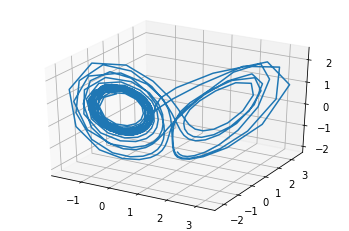

In [5]:
# Normalize, split data
states = (states - states.mean(0) ) / states.std(0) # normalize
testTrainSplit = int(states.shape[0] * trainToTest)

X = states[:-1,]
Y = states[1:,]

# Print Input
fig2 = plt.figure(2)
ax2 = fig2.gca(projection="3d")
if dim == 2:
    ax2 = plt.subplot()
    ax2.plot(X[:,0],X[:,1])
else:
    ax2.plot(X[:,0],X[:,1],X[:,2])
    
# Xt = np.column_stack((X[testTrainSplit:,], X[testTrainSplit-1:-1,1]))
Xt = X[testTrainSplit:,]
Yt = Y[testTrainSplit:,]
X = X[:testTrainSplit,]
Y = Y[:testTrainSplit,]


In [6]:
# GP setup
gp.setCovar("sqrexpo")
gp.setPrior(1,"half-normal")
# gp.setPrior(2,"half-normal")
gp.setData(X,Y)
gp.setTimeDelayInterval(1)
# gp.setDelayEmbedding([0,1,0])


Prior dict  {0: 'none', 1: 'none', 2: 'none', 3: 'none'}
Covariance function set to  sqrexpo
r =  8.660254037844386
Data input success


(1.0, -157.54830165284434) 163.29433879756206
Likelihood:  -1.4476268019719891
Hp:  [0.25 0.25 0.25 0.25]  #  1
(1.0, -528.9705223518) 241.69185841266656
Likelihood:  145.1680979078452
Hp:  [1.00e-06 3.75e-01 1.00e-06 1.00e-06]  #  2
(1.0, -4488.815020940417) 19621098.398015976
Likelihood:  -9808303.228273524
Hp:  [0.150001 0.525    0.150001 0.150001]  #  3
(1.0, -532.2247655350818) 99.91799205901353
Likelihood:  217.70420566673027
Hp:  [0.075001 0.45     0.075001 0.075001]  #  4
(1.0, -795.7748553344828) 113.34763103471495
Likelihood:  342.7737348363896
Hp:  [1.0e-06 3.6e-01 1.0e-06 1.0e-06]  #  5
(1.0, -4501.8780238119525) 20438643.1319814
Likelihood:  -10217069.0637548
Hp:  [0.045001 0.405    0.045001 0.045001]  #  6
(1.0, -994.5987934070474) 150.7702676805685
Likelihood:  423.4763703668484
Hp:  [0.022501 0.3825   0.099001 0.022501]  #  7
(1.0, -1158.3982291188527) 95.07650870333744
Likelihood:  533.2186805183322
Hp:  [1.0000e-06 3.5550e-01 7.2001e-02 1.0000e-06]  #  8
(1.0, -4028.6

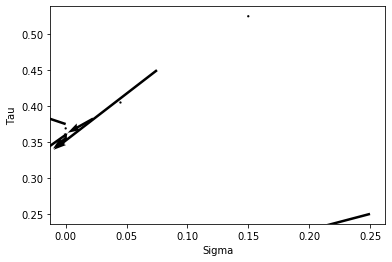

In [7]:

# optimize them parameters
gp.hyperParamOptimize(steps=40) # <<<< THIS IS EXPENSIVE

In [8]:
# One step predictions
diffTable = []
predictions = np.zeros((len(Xt),dim))
variances = np.zeros((len(Xt),1))
for i in range(len(Xt)):
    predTuple = gp.predict(Xt[i])
    variances[i] = predTuple[1]
    predictions[i] = predTuple[0] # list of one step prediction values for graphing
    
    diff = la.norm(Yt[i] - predictions[i]) # norm error for 1 step
    diffTable.append(diff)
# print("Predictions ", predictions)
# print("DiffTable ", diffTable)

diffTable = np.array(diffTable)

In [9]:
# feed forward prediction
n = 200 # num steps
feedForwardPrediction = np.zeros(((n,dim)))
feedForwardPrediction[0] = X[0]
for i in range(n-1):
    feedForwardPrediction[i+1] = gp.predict(feedForwardPrediction[i])[0]

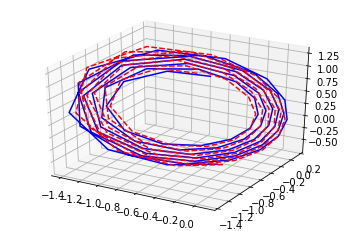

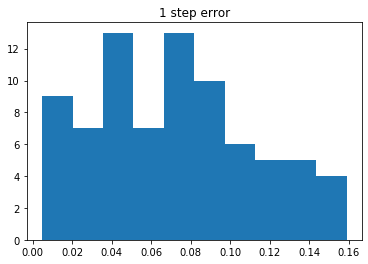

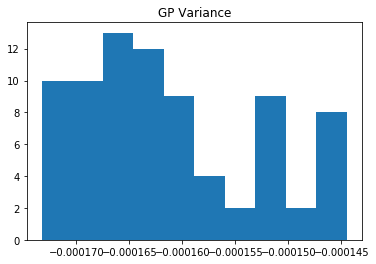

In [10]:
fig0 = plt.figure(0)
if dim == 2:
    ax0 = plt.subplot()
    ax0.plot(Yt[:,0],Yt[:,1],"b") # states
    ax0.plot(predictions[:,0],predictions[:,1],'--r') # map of 1 step ahead predictions
else:
    ax0 = fig0.gca(projection="3d")
    ax0.plot(Yt[:,0],Yt[:,1],Yt[:,2],"b") # states
    ax0.plot(predictions[:,0],predictions[:,1],predictions[:,2],'--r') # map of 1 step ahead predictions
    # ax0.plot(feedForwardPrediction[:,0],feedForwardPrediction[:,1],feedForwardPrediction[:,2],'--g') # map of 50 step ahead prediction

fig1 = plt.figure(1)
plt.title("1 step error")
plt.hist(diffTable)

fig2 = plt.figure(2)
plt.hist(variances)
plt.title("GP Variance")

plt.show()

[0.99626653 1.13648458 0.92737763]


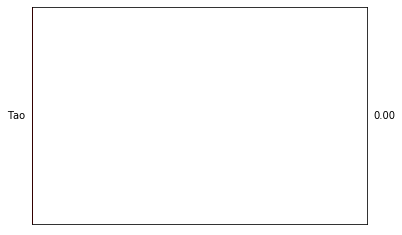

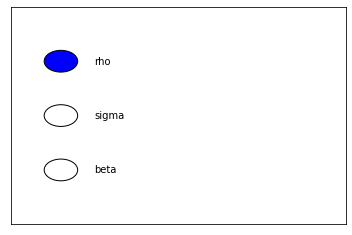

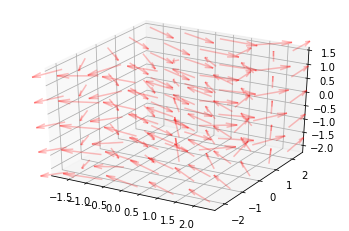

In [11]:
# This doesn't work in Jupyter lol
fig3 = plt.figure(3)
sliderAx = plt.axes()
slider = Slider(sliderAx,"Tao", 0, 50, valinit=0, valstep=0.1)

fig4 = plt.figure(4)
paramAx = plt.axes()
paramButtons = RadioButtons(paramAx, ("rho","sigma","beta"), active = 0)

def update(val):
    global rho, sigma, beta
    if (paramButtons.value_selected == "rho"):
        rho = slider.val
    elif (paramButtons.value_selected == "sigma"):
        sigma = slider.val
    elif (paramButtons.value_selected == "beta"):
        beta = slider.val

    # Line Plot Update
    s = odeint(LorenzP,t0,t, args=(rho,sigma,beta))
    ax2.clear()
    ax2.plot(s[:,0], s[:,1], s[:,2])

    # Quiver Update
    mi = np.nanmin(s,axis=0)
    ma = np.nanmax(s,axis=0)
    st = abs(mi - ma) / 5
    print(st)

    x, y, z = np.meshgrid(np.arange(mi[0],ma[0],st[0]), np.arange(mi[1],ma[1],st[1]),np.arange(mi[2],ma[2],st[2]))
    u, v, w = (sigma * (y - x), x * (rho - z) - y, x * y - beta * z)
    ax2.quiver(x,y,z,u,v,w,length=5,normalize=True, color = "r", alpha = 0.25)
    
    fig2.canvas.draw()
    fig2.canvas.flush_events()

def update2(val):
    global rho, sigma, beta
    if (paramButtons.value_selected == "rho"):
        slider.set_val(rho)
    elif (paramButtons.value_selected == "sigma"):
        slider.set_val(sigma)
    elif (paramButtons.value_selected == "beta"):
        slider.set_val(beta)

slider.on_changed(update)
paramButtons.on_clicked(update2)

# Quiver Plot
fig2 = plt.figure(2)
ax2 = fig2.gca(projection="3d")


mi = np.nanmin(X,axis=0)
ma = np.nanmax(X,axis=0)
st = abs(mi - ma) / 5
print(st)

x, y, z = np.meshgrid(np.arange(mi[0],ma[0],st[0]), np.arange(mi[1],ma[1],st[1]),np.arange(mi[2],ma[2],st[2]))
u, v, w = (sigma * (y - x), x * (rho - z) - y, x * y - beta * z)
ax2.quiver(x,y,z,u,v,w,length=st[0],normalize=True, color = "r", alpha=0.25)

plt.show()